# Exploración de los datos (EDA)



In [1]:
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.ion()

sns.set(style="darkgrid")
%matplotlib inline

## Descripción del Dataset y problema

Para el sistema de transporte de gas natural, contar con predicciones precisas de la demanda es vital, ya que permite optimizar la programación de envíos, reducir costos operativos y minimizar riesgos. Una predicción adecuada permite planificar mejor la capacidad de transporte, evitar sobrecargas o escasez en la red de gasoductos y asegurar la continuidad del suministro para los consumidores. Además, mejora la capacidad de respuesta ante eventos inesperados y facilita la toma de decisiones basadas en datos.

El siguiente DF contiene la información de consumo diaria de una población.


## Data:

In [2]:
data = pd.read_excel("../../data/consumo.xlsx")
# Transformar a datetime
data["DateTime"] = pd.to_datetime(data["FECHA"])
data.set_index("DateTime", inplace=True)
data.drop(columns="FECHA", inplace=True)

timeserie = data["CONSUMO"]

In [3]:
data.head()

,CONSUMO,FESTIVO
DateTime,,
2014-01-01,1025.77354,Año_nuevo
2014-01-02,1478.33453,Normal
2014-01-03,1610.05269,Normal
2014-01-04,1578.83430,Normal
2014-01-05,1328.31417,Normal


In [4]:
# verificamos si hay datos faltantes
data.isnull().sum()


CONSUMO    0
FESTIVO    0
dtype: int64

In [5]:
data.shape

(3796, 2)

In [6]:
"El rango analizado va desde "+ str(data.index.min()) +" hasta "+ str(data.index.max())

'El rango analizado va desde 2014-01-01 00:00:00 hasta 2024-05-23 00:00:00'

Se tiene información horaria de más de 5 años, entre 2019 y 2024. NO hay valores nulos, lo representa un total de 46011 filas y 9 columnas.

## Gráficos:

Inicialmente se visualizar la información horaria de producción y consumo:

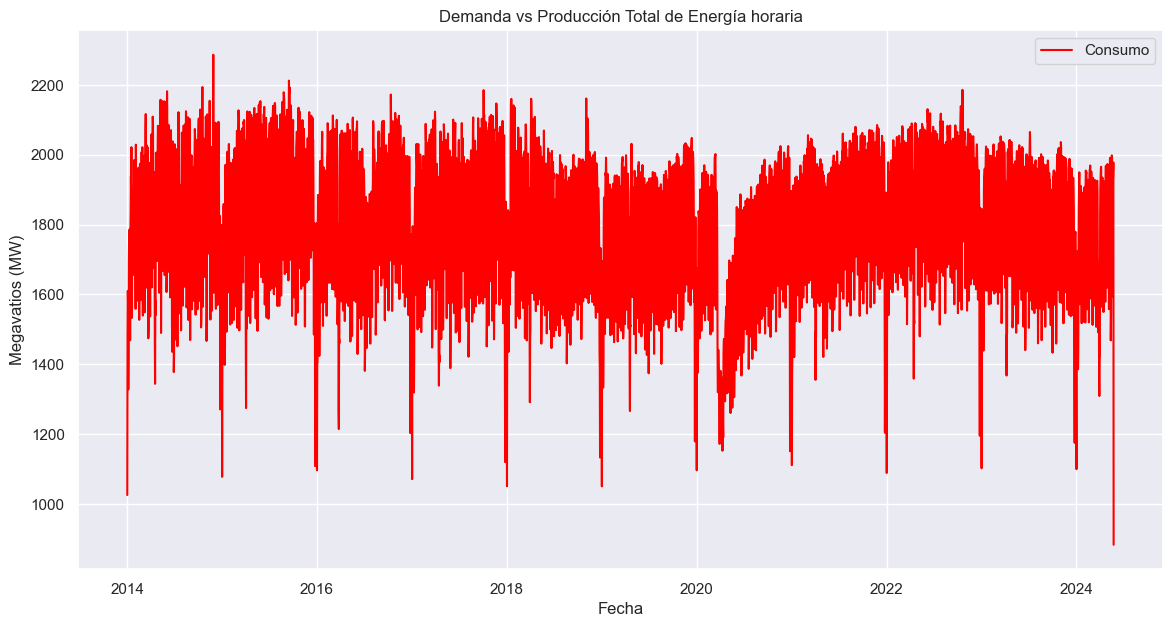

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(timeserie, label='Consumo', color='red')
plt.title('Demanda vs Producción Total de Energía horaria')
plt.xlabel('Fecha')
plt.ylabel('Megavatios (MW)')
plt.legend()
plt.show()

No obstante, esa información gráficamente es confusa no permite apreciar tendencias claras, por lo que procedemos a agregarla (para visualizar mejor)

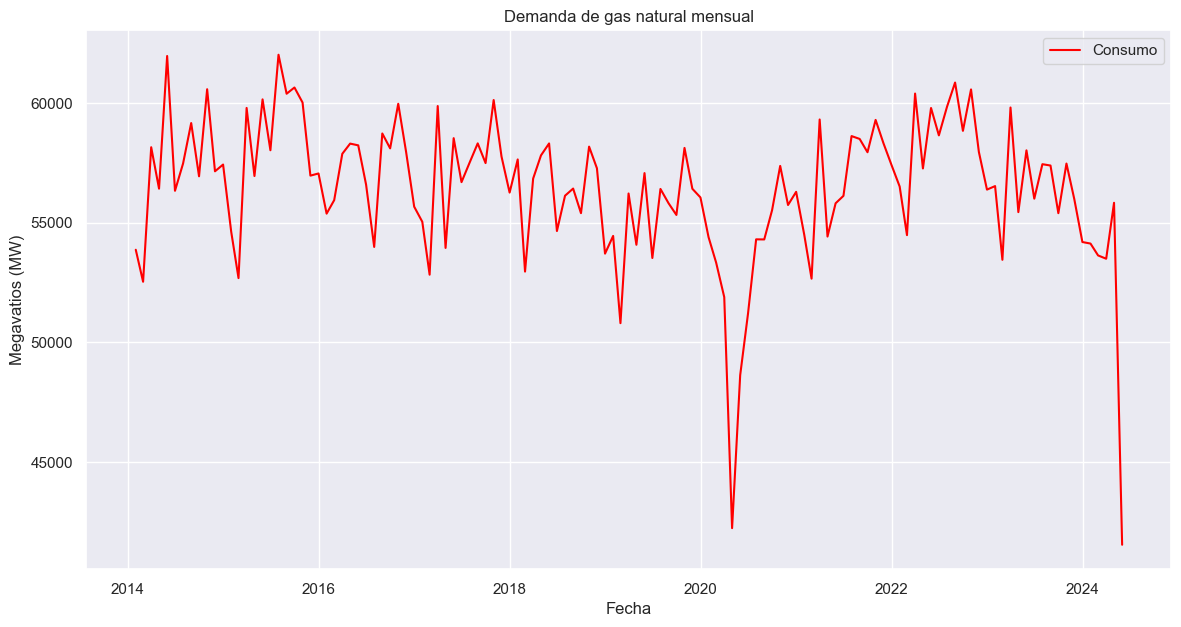

In [8]:
# Agregar datos a intervalos diarios
data_mes = timeserie.resample('ME').sum()

plt.figure(figsize=(14, 7))
plt.plot(data_mes, label='Consumo', color='red')
plt.title('Demanda de gas natural mensual')
plt.xlabel('Fecha')
plt.ylabel('Megavatios (MW)')
plt.legend()
plt.show()

<Axes: xlabel='CONSUMO', ylabel='Count'>

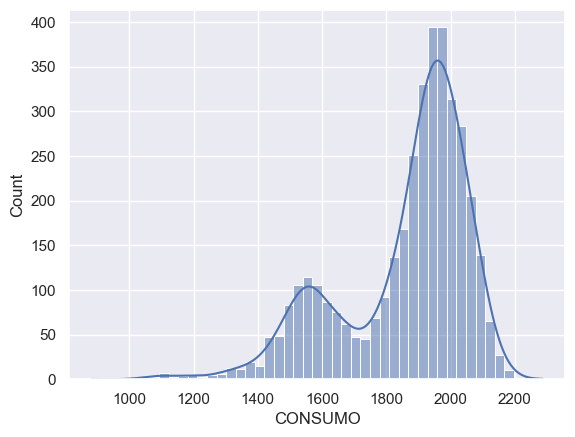

In [9]:
sns.histplot(timeserie , kde=True)

Con lo anterior, se observa que nuestros datos tiene una dsitribución bimodal. Veamos a continuación

In [10]:
data_transform = data.copy()

# Tipo de día de consumo
data_transform["TIPO_DIA"] = (data_transform["FESTIVO"] == "Normal") * 1
data_transform.replace({"TIPO_DIA":{1:"NORMAL", 0:"FESTIVO"}}, inplace=True)

# día de la semana
data_transform["DIA_SEM"] = data_transform.index.weekday
data_transform["MES"] = data_transform.index.map(lambda x: x.month)
data_transform["AÑO"] = data_transform.index.map(lambda x: x.year)

# Pandemia 
inicio_cuarentena = pd.to_datetime("25/03/2020", dayfirst=True)
fin_cuarentena = pd.to_datetime("31/08/2020", dayfirst=True)

data_transform["PANDEMIA"] = (data_transform.index >= inicio_cuarentena ) & (data_transform.index <= fin_cuarentena ) * 1

data_transform.head()

,CONSUMO,FESTIVO,TIPO_DIA,DIA_SEM,MES,AÑO,PANDEMIA
DateTime,,,,,,,
2014-01-01,1025.77354,Año_nuevo,FESTIVO,2,1,2014,0
2014-01-02,1478.33453,Normal,NORMAL,3,1,2014,0
2014-01-03,1610.05269,Normal,NORMAL,4,1,2014,0
2014-01-04,1578.83430,Normal,NORMAL,5,1,2014,0
2014-01-05,1328.31417,Normal,NORMAL,6,1,2014,0


In [11]:
data_transform["PANDEMIA"].value_counts()

PANDEMIA
0    3636
1     160
Name: count, dtype: int64

<Axes: xlabel='TIPO_DIA', ylabel='CONSUMO'>

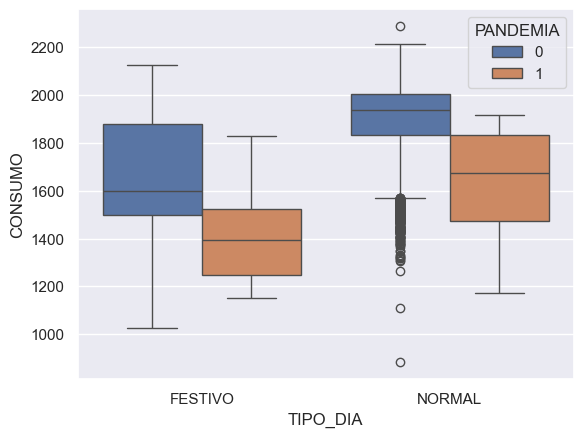

In [12]:
sns.boxplot(data=data_transform, x = "TIPO_DIA", y = "CONSUMO", hue='PANDEMIA')

<Axes: xlabel='DIA_SEM', ylabel='CONSUMO'>

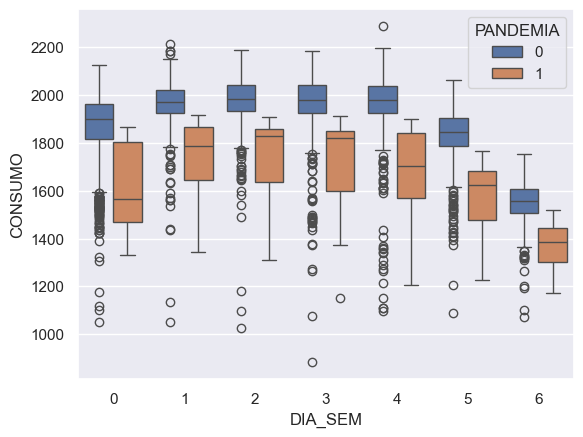

In [13]:
sns.boxplot(data=data_transform, x ="DIA_SEM", y = "CONSUMO", hue='PANDEMIA')

<Axes: xlabel='DIA_SEM', ylabel='CONSUMO'>

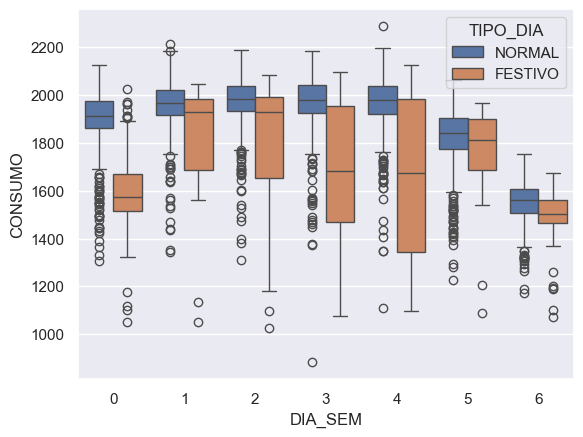

In [14]:
sns.boxplot(data=data_transform, x ="DIA_SEM", y = "CONSUMO", hue='TIPO_DIA')

<Axes: xlabel='DIA_SEM', ylabel='CONSUMO'>

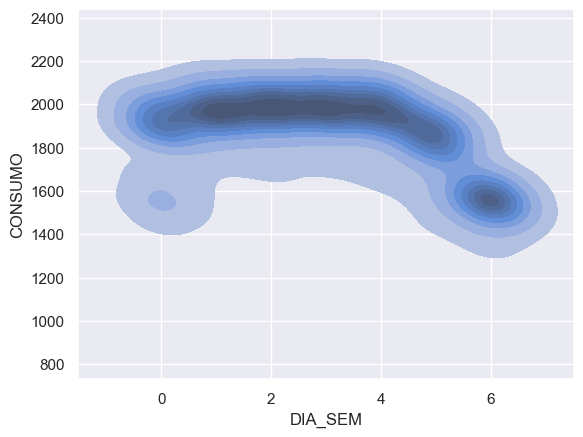

In [15]:
sns.kdeplot(data_transform, x = "DIA_SEM", y = "CONSUMO", fill=True)

Con lo anterior, es proabable que la bimodalidad se deba 

<Axes: xlabel='CONSUMO', ylabel='Count'>

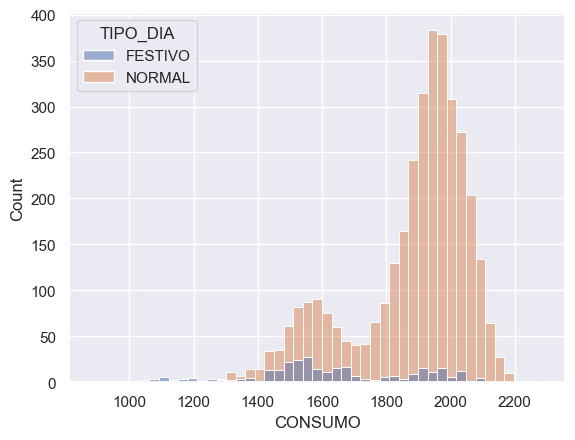

In [16]:
sns.histplot(data_transform, x="CONSUMO", hue="TIPO_DIA")

<Axes: xlabel='CONSUMO', ylabel='Count'>

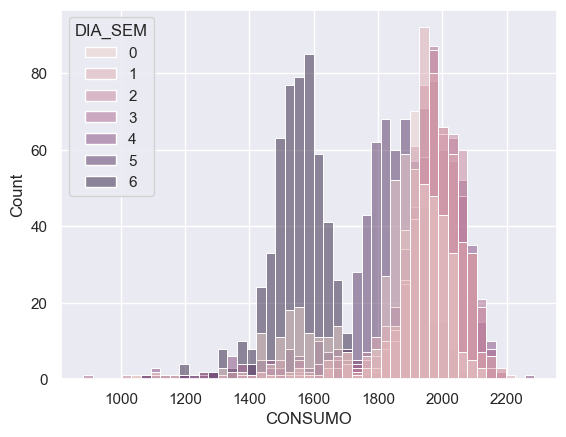

In [17]:
sns.histplot(data_transform, x="CONSUMO", hue="DIA_SEM")

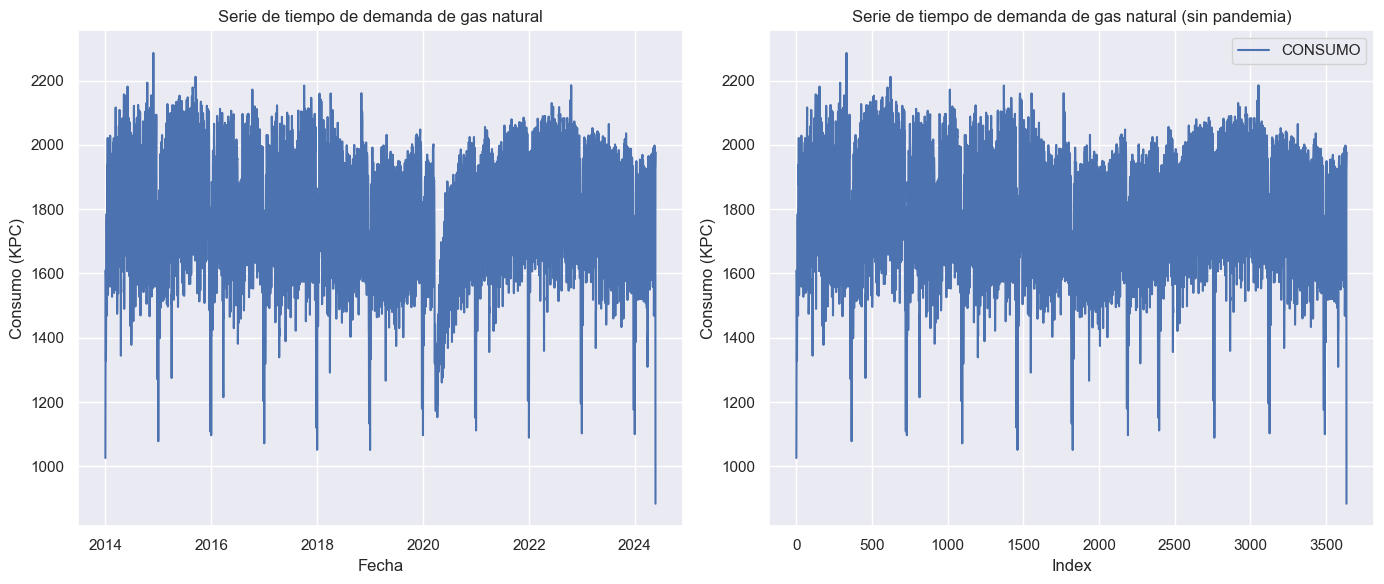

In [18]:
timeserie_no_pandemia = timeserie.loc[data_transform["PANDEMIA"]== 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# timeserie con pandemia
sns.lineplot(timeserie, ax=ax1)
ax1.set_title("Serie de tiempo de demanda de gas natural")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Consumo (KPC)")

# timeserie sin pandemia (Reset_index)
sns.lineplot(timeserie_no_pandemia.reset_index(), ax=ax2)
ax2.set_title("Serie de tiempo de demanda de gas natural (sin pandemia)")
ax2.set_xlabel("Index")
ax2.set_ylabel("Consumo (KPC)")

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [19]:
timeserie_norm_semana_no_pandemia = data_transform.loc[(data_transform["TIPO_DIA"]=="NORMAL") & (data_transform["DIA_SEM"]<5) & (data_transform["PANDEMIA"]==0)].CONSUMO

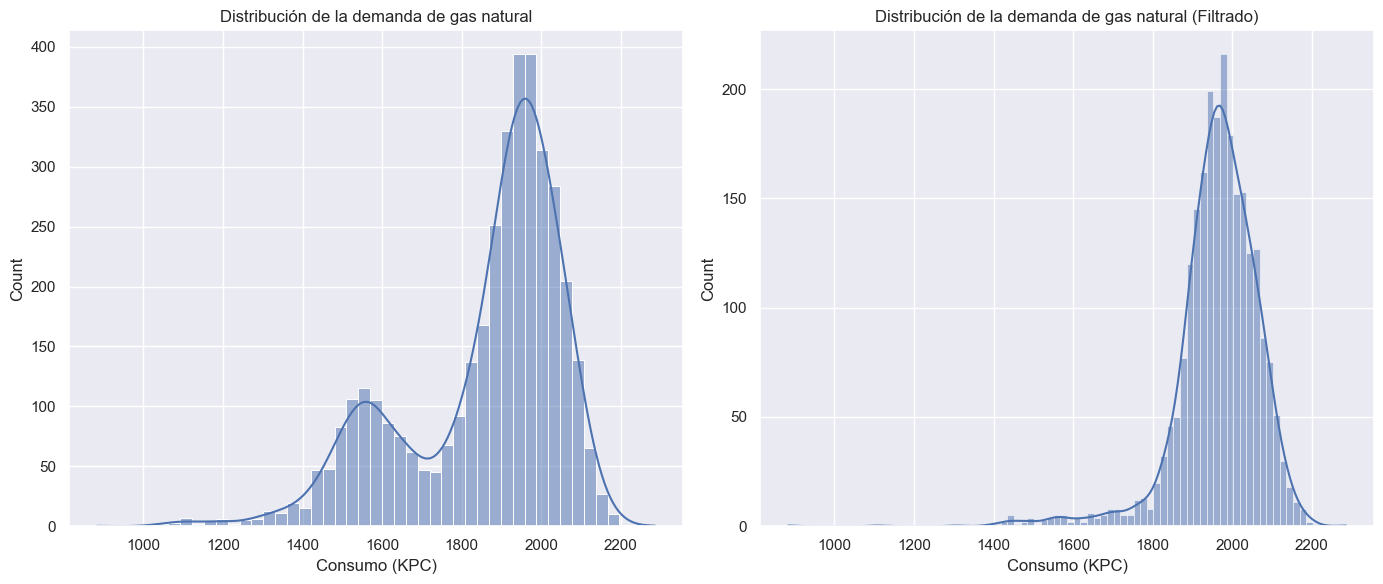

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# timeserie con pandemia
sns.histplot(timeserie, kde=True, ax=ax1)
ax1.set_title("Distribución de la demanda de gas natural")
ax1.set_xlabel("Consumo (KPC)")


# timeserie sin pandemia (Reset_index)
sns.histplot(timeserie_norm_semana_no_pandemia, kde=True, ax=ax2)
ax2.set_title("Distribución de la demanda de gas natural (Filtrado)")
ax2.set_xlabel("Consumo (KPC)")

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

<Axes: xlabel='CONSUMO', ylabel='Count'>

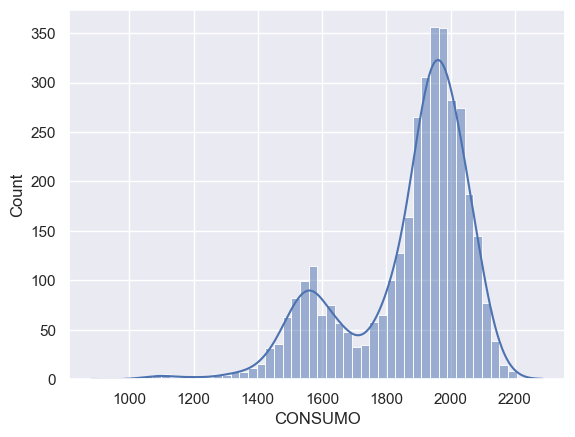

In [21]:
timeserie_no_pandemia = data_transform.loc[data_transform["PANDEMIA"]==0].CONSUMO
sns.histplot(timeserie_no_pandemia, kde=True)

## Estacionalidad

<Axes: xlabel='MES', ylabel='CONSUMO'>

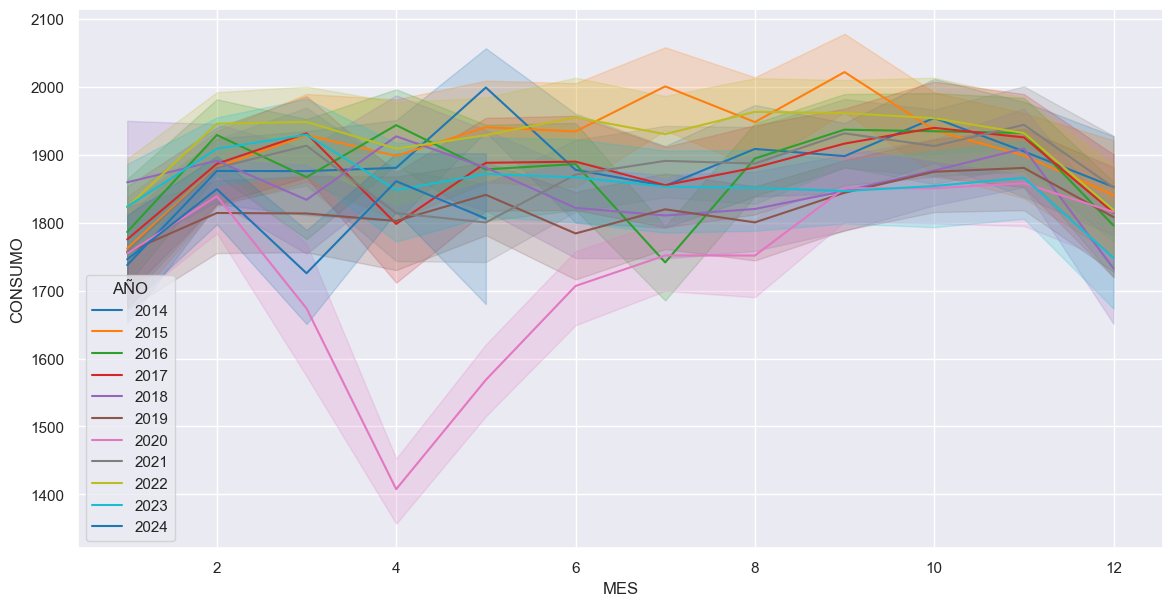

In [22]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=data_transform, x='MES', y='CONSUMO', hue='AÑO', palette='tab10')


<Axes: xlabel='DIA_SEM', ylabel='CONSUMO'>

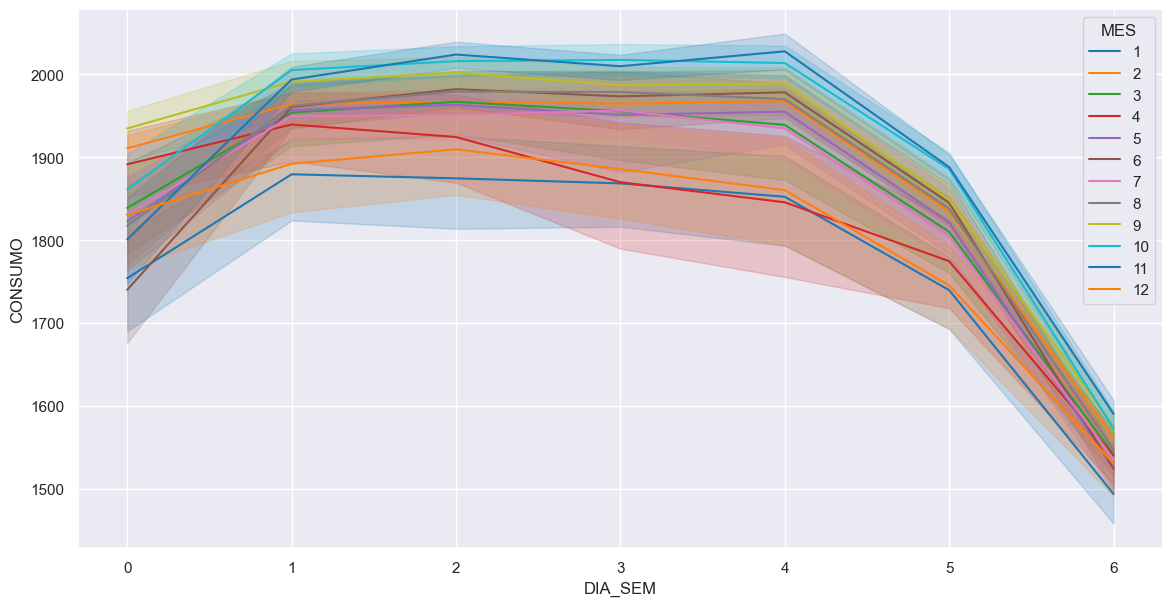

In [23]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=data_transform, x='DIA_SEM', y='CONSUMO', hue='MES', palette='tab10')


## Conclusiones:

A partir de la información analizada es posible concluir 

- El consumo de gas para la población analizada varía entre semanas y fines de semana
- El consumo de gas se vio afectado por pandemia, creando un patrón anormal. Se recomienda excluirlo del análisis
- El cosumo de gas también se ve afectado por los días festivos, incluso entre semanas. Por tanto es probable que se deban considerar como variable exógena

In [24]:
data_transform.to_csv('../../data/consumo_silver.csv')